<a href="https://colab.research.google.com/github/hamednasr/deep-learning/blob/main/DUDL_transfer_pretrainFMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Transfer learning
### LECTURE: Pretraining with autoencoders
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202109

In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import a dataset

In [4]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



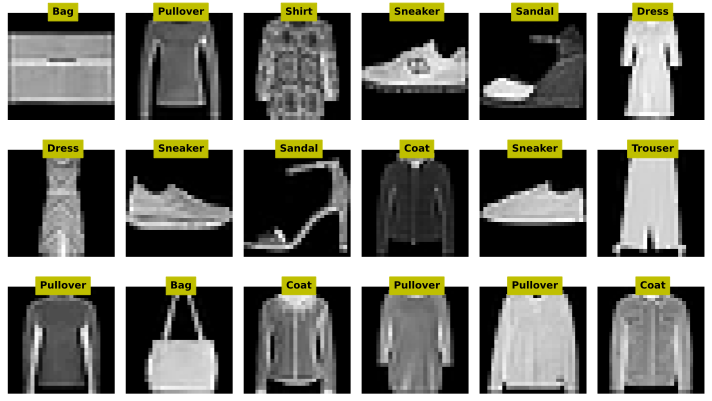

In [5]:
# inspect a few random images
X,y = next(iter(test_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization
  
  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create the autoencoder model

In [6]:
# create a class for the model
def makeTheAENet(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- encoder layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      

      ### -------------- decoder layers -------------- ###
      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(16,1,4,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      

    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # first decoder layer
      x = F.leaky_relu(self.decconv1(x))
      if self.print: print(f'First decoder layer: {list(x.shape)}')

      # second decoder layer
      x = F.leaky_relu(self.decconv2(x))
      if self.print: print(f'Second decoder layer: {list(x.shape)}')

      return x

  # create the model instance
  net = aenet(printtoggle)
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [7]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeTheAENet(True)

X,y = iter(train_loader).next()
yHat = tmpnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
First decoder layer: [32, 16, 14, 14]
Second decoder layer: [32, 1, 28, 28]

Output size:
torch.Size([32, 1, 28, 28])
 
Loss:
tensor(0.8093, grad_fn=<MseLossBackward0>)


# Create a function that trains the AUTOENCODER model

In [8]:
# a function that trains the model

def function2trainTheAEModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheAENet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,X)

    # and get average losses and accuracies across the batches
    devLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,devLoss,net

# Run the model and show the results!

In [9]:
# ~3 minutes with 10 epochs on GPU
trainLoss,devLoss,aenet = function2trainTheAEModel()

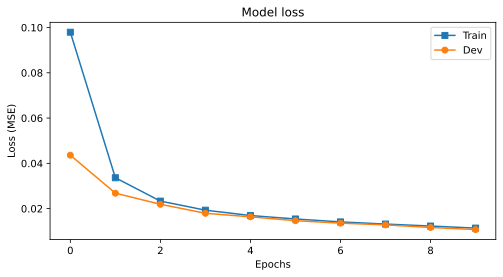

In [10]:
fig = plt.figure(figsize=(8,4))

plt.plot(trainLoss,'s-',label='Train')
plt.plot(devLoss,'o-',label='Dev')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')
plt.legend()

plt.show()

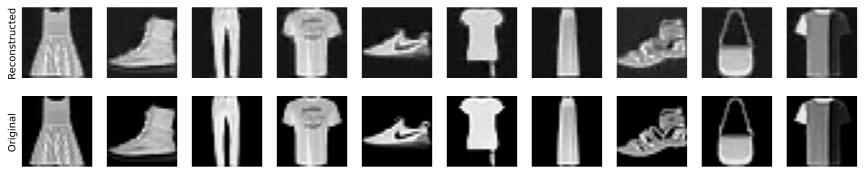

In [11]:
## show some random examples

# get some data
X,y = next(iter(dev_loader))

# forward pass and loss
aenet.cpu()
aenet.eval() # switch to test mode
yHat = aenet(X)

fig,axs = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
  pic = yHat[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].axis('off')

  pic = X[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic,cmap='gray')
  axs[1,i].axis('off')

  if i==0:
    axs[0,0].text(-6,14,'Reconstructed',rotation=90,va='center')
    axs[1,0].text(-6,14,'Original',rotation=90,va='center')

  
plt.show()

# Now create a new model that does classification

In [12]:
# create a class for the model
def makeTheClassNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- encoder layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(1,16,3,padding=1,stride=2)
      # output size: (28+2*1-3)/2 + 1 = 14

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,3,padding=1,stride=2)
      # output size: (14+2*1-3)/2 + 1 = 7
      

      ### ------------- linear layers ------------- ###
      self.fc1  = nn.Linear(7*7*32,50)
      self.fc2  = nn.Linear(50,10)
      

    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first encoder layer
      x = F.leaky_relu(self.encconv1(x))
      if self.print: print(f'First encoder layer: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.encconv2(x))
      if self.print: print(f'Second encoder layer: {list(x.shape)}')

      # reshape to linear
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Post-convolution vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      if self.print: print(f'First linear layer: {list(x.shape)}')

      x = F.leaky_relu(self.fc2(x))
      if self.print: print(f'Second linear layer: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [13]:
# test the model with one batch
tmpnet,lossfun,optimizer = makeTheClassNet(True)

X,y = iter(train_loader).next()
yHat = tmpnet(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First encoder layer: [32, 16, 14, 14]
Second encoder layer: [32, 32, 7, 7]
Post-convolution vectorized: [32, 1568]
First linear layer: [32, 50]
Second linear layer: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3103, grad_fn=<NllLossBackward0>)


# Now we need another function to train the classifier

In [14]:
# a function that trains the model

def function2trainTheClassModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10
  
  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

    # and get average losses and accuracies across the batches
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()
  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

In [15]:
# train a new model from scratch (not pre-trained!)

# create a naive network
naivenet,lossfun,optimizer = makeTheClassNet()

# train it from scratch
trainLossNaive,devLossNaive,trainAccNaive,devAccNaive,naivenet = function2trainTheClassModel(naivenet,lossfun,optimizer)


## evaluate on the test set
naivenet.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = naivenet(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLossNaive = loss.item()
testAccNaive  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

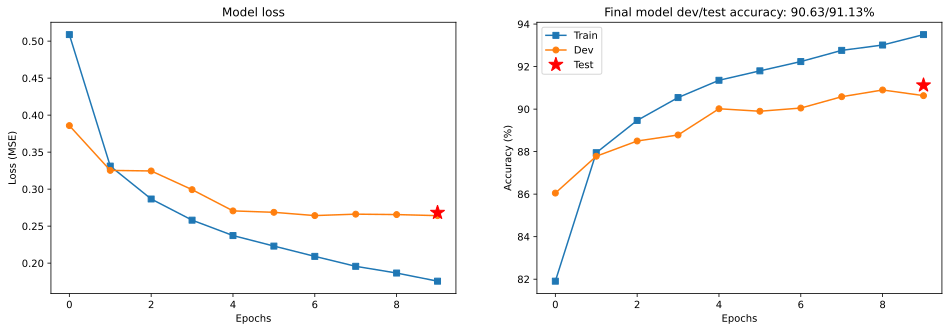

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossNaive,'s-',label='Train')
ax[0].plot(devLossNaive,'o-',label='Dev')
ax[0].plot(len(devLossNaive)-1,testLossNaive,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccNaive,'s-',label='Train')
ax[1].plot(devAccNaive,'o-',label='Dev')
ax[1].plot(len(devAccNaive)-1,testAccNaive,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAccNaive[-1]:.2f}/{testAccNaive:.2f}%')
ax[1].legend()

plt.show()

# Build a new model but replace the convolution layers with with AE layer

In [17]:
pretrainNet,lossfun,optimizer = makeTheClassNet()

#### Note about the code below: Both networks have the same number of layers overall; in other applications
#    you may need to modify the code to find the matching layers.

# then replace the conv weights in TARGET model from encoder weights in SOURCE model
for target,source in zip(pretrainNet.named_parameters(),aenet.named_parameters()):
  print('PRETRAIN: ' + target[0] + '  AENET: ' + source[0])
  if 'enc' in target[0]:
    target[1].data = copy.deepcopy( source[1].data )


PRETRAIN: encconv1.weight  AENET: encconv1.weight
PRETRAIN: encconv1.bias  AENET: encconv1.bias
PRETRAIN: encconv2.weight  AENET: encconv2.weight
PRETRAIN: encconv2.bias  AENET: encconv2.bias
PRETRAIN: fc1.weight  AENET: decconv1.weight
PRETRAIN: fc1.bias  AENET: decconv1.bias
PRETRAIN: fc2.weight  AENET: decconv2.weight
PRETRAIN: fc2.bias  AENET: decconv2.bias


In [29]:
for p in pretrainNet.named_parameters():
  print(p[0])

encconv1.weight
encconv1.bias
encconv2.weight
encconv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [30]:
# freezing the copied layers

for p in pretrainNet.named_parameters():
  if 'encconv' in p[0]:
    p[1].requires_grad = False

In [31]:
for p in pretrainNet.named_parameters():
  print(p[1].requires_grad)

False
False
False
False
True
True
True
True


In [32]:
# train the pretrained model

# training
trainLossPre,devLossPre,trainAccPre,devAccPre,pretrainNet = function2trainTheClassModel(pretrainNet,lossfun,optimizer)


## evaluate on the test set
pretrainNet.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = pretrainNet(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLossPre = loss.item()
testAccPre  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

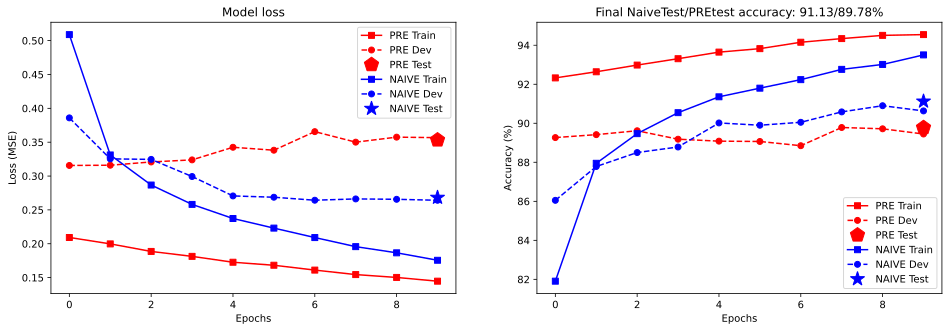

In [33]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLossPre,'rs-',label='PRE Train')
ax[0].plot(devLossPre,'ro--',label='PRE Dev')
ax[0].plot(len(devLossPre)-1,testLossPre,'rp',markersize=15,label='PRE Test')
ax[0].plot(trainLossNaive,'bs-',label='NAIVE Train')
ax[0].plot(devLossNaive,'bo--',label='NAIVE Dev')
ax[0].plot(len(devLossNaive)-1,testLossNaive,'b*',markersize=15,label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAccPre,'rs-',label='PRE Train')
ax[1].plot(devAccPre,'ro--',label='PRE Dev')
ax[1].plot(len(devAccPre)-1,testAccPre,'rp',markersize=15,label='PRE Test')
ax[1].plot(trainAccNaive,'bs-',label='NAIVE Train')
ax[1].plot(devAccNaive,'bo--',label='NAIVE Dev')
ax[1].plot(len(devAccNaive)-1,testAccNaive,'b*',markersize=15,label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {testAccNaive:.2f}/{testAccPre:.2f}%')
ax[1].legend()

plt.show()

# Perhaps they differ by feature map activation?

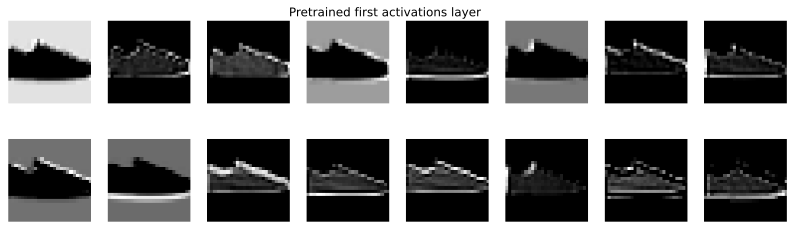

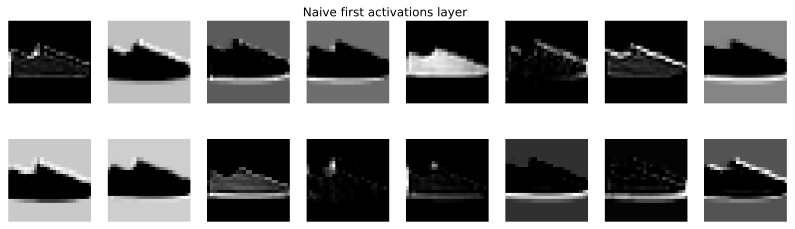

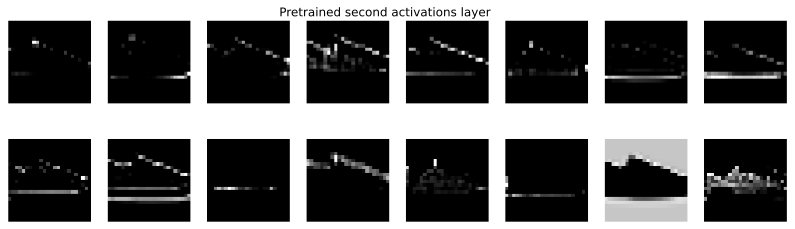

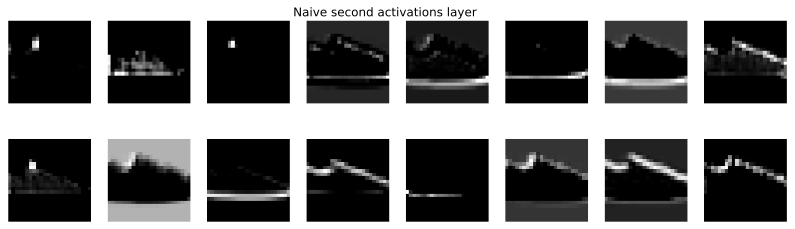

In [36]:
# grab one image
x = X[10,:,:,:].view(1,1,28,28)

# compute the activations of the first layer (excluding the bias b/c this is simply a constant)
layer1ActPre = F.relu( F.conv2d(x,pretrainNet.encconv1.weight) )
layer1ActNai = F.relu( F.conv2d(x,naivenet.encconv1.weight) )

layer2ActPre = F.relu( F.conv2d(layer1ActPre,pretrainNet.encconv2.weight) )
layer2ActNai = F.relu( F.conv2d(layer1ActNai,naivenet.encconv2.weight) )


## show the first feature map activations for the pretrained model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActPre[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Pretrained first activations layer',y=.9)
plt.show()

## show the first feature map activations for the naive model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActNai[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Naive first activations layer',y=.9)
plt.show()




## show the second feature map activations for the pretrained model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer2ActPre[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Pretrained second activations layer',y=.9)
plt.show()



## show the second feature map activations for the naive model
fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer2ActNai[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Naive second activations layer',y=.9)
plt.show()

# Additional explorations

In [35]:
# 1) Computing the activation of the first layer is fairly straight forward, but gets more complicated as you go deeper
#    into the model. Perhaps more insight into the differences between the native and pretrained models will come from
#    inspecting the activation of the second convolution layer. To examine this, you can modify the network classes to 
#    output the activation maps (see lecture "Examine feature map activations" from CNN section). Does examining the
#    feature map activations of this layer provide any more insight into the differences in performance between the
#    two different models?
# 
# 2) Here we used pretraining as a "smart weight initialization," but you can also pretrain and freeze the copied layers. 
#    Given the performance seen above, it's unlikely that freezing the convolution layers (instead of allowing them to
#    continue learning) will increase performance, but it (1) is a great opportunity for you to practice freezing layers
#    and (2) will be interesting to see whether the frozen model does worse or the same as the pretrainNet.
# 